In [1]:
#  STEP 1: Import basic libraries
import pandas as pd
import numpy as np

#  Upload CSV from your computer (manual upload method)
from google.colab import files
uploaded = files.upload()

#  Load CSV to dataframe
import io
df = pd.read_csv(io.BytesIO(uploaded['ecommerce_customer_sales_data.csv']))

#  Preview the data
df.head()


Saving ecommerce_customer_sales_data.csv to ecommerce_customer_sales_data.csv


,CustomerID,CustomerName,Age,Gender,IncomeLevel,LoyaltyScore,CustomerSegment,Location,ProductID,Category,...,Brand,CostPrice,SellingPrice,DiscountOffered,PurchaseQuantity,UnitPrice,PaymentMethod,DateOfPurchase,SalesChannel,PaymentStatus
0,1051,Customer_0,51,Male,Low,82,C,Hyderabad,2943,Clothing,...,BrandZ,456,1184,10,2,1121,Credit Card,2023-01-01,Offline,Paid
1,1092,Customer_1,64,Female,Low,92,B,Mumbai,2038,Beauty,...,BrandZ,756,275,15,1,633,Cash,2023-01-02,Online,Paid
2,1014,Customer_2,25,Female,Medium,51,B,Mumbai,2488,Clothing,...,BrandZ,843,455,5,1,1078,Cash,2023-01-03,Offline,Paid
3,1071,Customer_3,57,Male,High,47,B,Delhi,2643,Beauty,...,BrandX,971,777,20,3,298,Net Banking,2023-01-04,Offline,Pending
4,1060,Customer_4,61,Female,Medium,4,C,Bangalore,2541,Beauty,...,BrandY,303,838,0,4,1136,UPI,2023-01-05,Offline,Pending


In [2]:
#  Dataset shape
print("Dataset shape:", df.shape)

#  Column-wise datatype & non-null info
print("\n--- Dataset Info ---")
df.info()

#  Missing/null value check
print("\n--- Null Value Check ---")
print(df.isnull().sum())


Dataset shape: (1000, 21)

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        1000 non-null   int64 
 1   CustomerName      1000 non-null   object
 2   Age               1000 non-null   int64 
 3   Gender            1000 non-null   object
 4   IncomeLevel       1000 non-null   object
 5   LoyaltyScore      1000 non-null   int64 
 6   CustomerSegment   1000 non-null   object
 7   Location          1000 non-null   object
 8   ProductID         1000 non-null   int64 
 9   Category          1000 non-null   object
 10  SubCategory       1000 non-null   object
 11  Brand             1000 non-null   object
 12  CostPrice         1000 non-null   int64 
 13  SellingPrice      1000 non-null   int64 
 14  DiscountOffered   1000 non-null   int64 
 15  PurchaseQuantity  1000 non-null   int64 
 16  UnitPrice    

In [4]:
#  Make a copy to keep original safe
df_fe = df.copy()

#  1. Calculate Customer Lifetime Value (CLV)
# CLV = Total Purchase Value = UnitPrice × PurchaseQuantity
df_fe['CLV'] = df_fe['UnitPrice'] * df_fe['PurchaseQuantity']

#  2. Convert DateOfPurchase to datetime
df_fe['DateOfPurchase'] = pd.to_datetime(df_fe['DateOfPurchase'])

#  3. Recency = Latest Date - Customer’s Last Purchase
latest_date = df_fe['DateOfPurchase'].max()
recency_df = df_fe.groupby('CustomerID')['DateOfPurchase'].max().reset_index()
recency_df['RecencyDays'] = (latest_date - recency_df['DateOfPurchase']).dt.days

# Merge recency back
df_fe = df_fe.merge(recency_df[['CustomerID', 'RecencyDays']], on='CustomerID', how='left')

#  4. Discount % (optional feature)
df_fe['DiscountPercent'] = (df_fe['DiscountOffered'] / df_fe['SellingPrice']) * 100

#  5. Loyalty Bucket (High/Medium/Low)
def loyalty_label(score):
    if score >= 75:
        return 'High'
    elif score >= 40:
        return 'Medium'
    else:
        return 'Low'

df_fe['LoyaltyBucket'] = df_fe['LoyaltyScore'].apply(loyalty_label)

#  Preview engineered dataset
df_fe[['CustomerID', 'CLV', 'RecencyDays', 'DiscountPercent', 'LoyaltyScore', 'LoyaltyBucket']].head()


,CustomerID,CLV,RecencyDays,DiscountPercent,LoyaltyScore,LoyaltyBucket
0,1051,2242,43,0.844595,82,High
1,1092,633,84,5.454545,92,High
2,1014,1078,21,1.098901,51,Medium
3,1071,894,161,2.574003,47,Medium
4,1060,4544,50,0.000000,4,Low


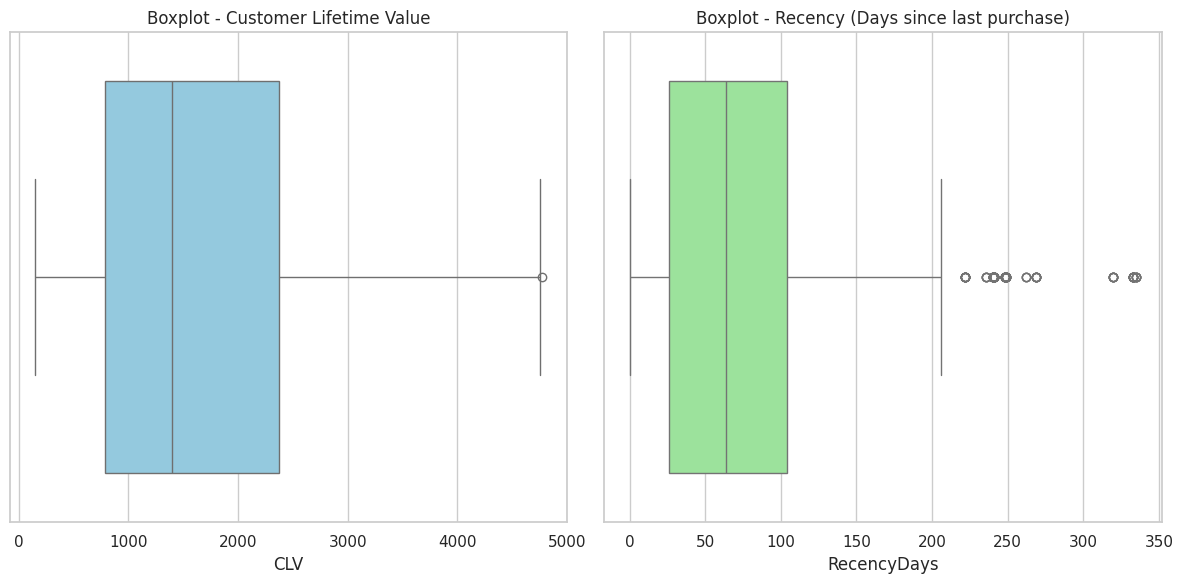

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set default style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

#  Boxplot: CLV (Customer Lifetime Value)
plt.subplot(1, 2, 1)
sns.boxplot(x=df_fe['CLV'], color='skyblue')
plt.title('Boxplot - Customer Lifetime Value')

#  Boxplot: RecencyDays
plt.subplot(1, 2, 2)
sns.boxplot(x=df_fe['RecencyDays'], color='lightgreen')
plt.title('Boxplot - Recency (Days since last purchase)')

plt.tight_layout()
plt.show()



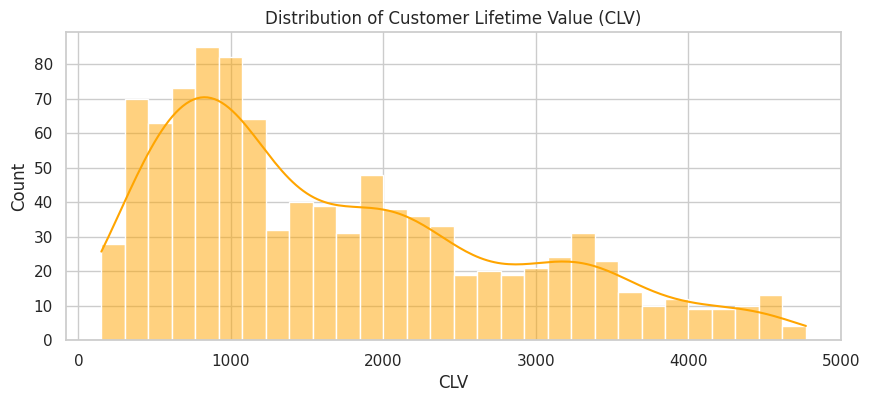

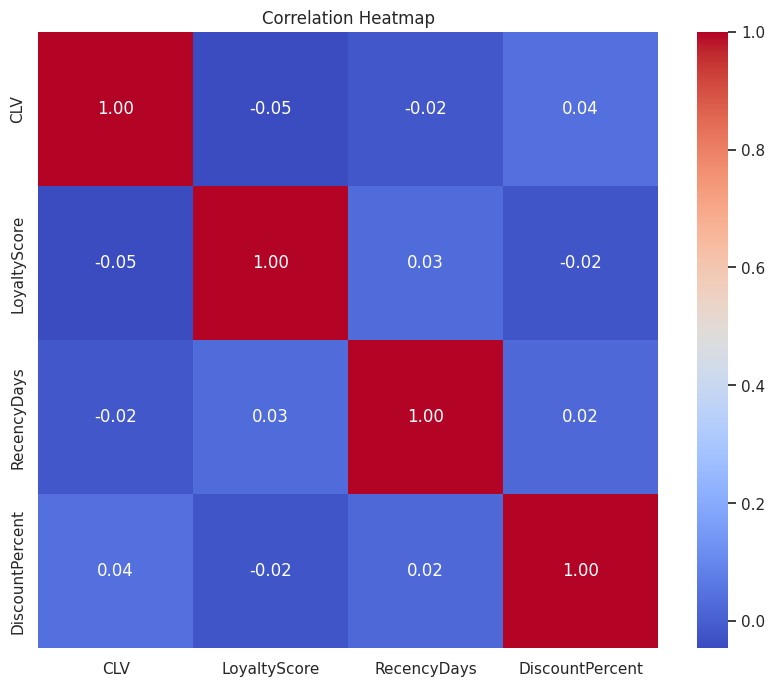

In [7]:
#  Distribution plot of CLV
plt.figure(figsize=(10, 4))
sns.histplot(df_fe['CLV'], kde=True, bins=30, color='orange')
plt.title("Distribution of Customer Lifetime Value (CLV)")
plt.xlabel("CLV")
plt.show()

#  Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_cols = ['CLV', 'LoyaltyScore', 'RecencyDays', 'DiscountPercent']
corr = df_fe[numeric_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [8]:
#  RFM Table using Recency, Frequency, Monetary (CLV)
rfm = df_fe.groupby('CustomerID').agg({
    'RecencyDays': 'min',
    'CLV': 'sum',
    'DateOfPurchase': 'count'  # Purchase frequency
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Monetary', 'Frequency']
rfm.head()


,CustomerID,Recency,Monetary,Frequency
0,1000,46,36024,16
1,1001,32,26409,13
2,1002,26,19845,12
3,1003,91,17755,11
4,1004,68,22661,11


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

#  Feature Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

#  Apply GMM Clustering
gmm = GaussianMixture(n_components=4, random_state=42)
rfm['Segment'] = gmm.fit_predict(rfm_scaled)

rfm.head()


,CustomerID,Recency,Monetary,Frequency,Segment
0,1000,46,36024,16,2
1,1001,32,26409,13,0
2,1002,26,19845,12,0
3,1003,91,17755,11,0
4,1004,68,22661,11,0


In [10]:
# Merge customer segments back into full dataset
df_fe = df_fe.merge(rfm[['CustomerID', 'Segment']], on='CustomerID', how='left')

# Preview
df_fe[['CustomerID', 'CLV', 'RecencyDays', 'LoyaltyScore', 'Segment']].head()


,CustomerID,CLV,RecencyDays,LoyaltyScore,Segment
0,1051,2242,43,82,0
1,1092,633,84,92,0
2,1014,1078,21,51,0
3,1071,894,161,47,3
4,1060,4544,50,4,0


In [11]:
#  Group by Segment for summary
segment_summary = df_fe.groupby('Segment').agg({
    'CustomerID': 'nunique',
    'CLV': 'mean',
    'RecencyDays': 'mean',
    'LoyaltyScore': 'mean',
    'DiscountPercent': 'mean'
}).reset_index()

# Rename columns for clarity
segment_summary.columns = ['Segment', 'Customer Count', 'Avg CLV', 'Avg Recency', 'Avg Loyalty', 'Avg Discount%']
segment_summary


,Segment,Customer Count,Avg CLV,Avg Recency,Avg Loyalty,Avg Discount%
0,0,49,1614.258189,47.337187,50.354528,2.004331
1,1,11,1472.250000,262.805556,51.000000,2.317071
2,2,14,1995.040724,92.669683,49.728507,1.946808
3,3,26,1690.686170,96.510638,53.920213,1.997284


/tmp/ipython-input-12-2194407501.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Segment', data=df_fe, palette='Set2')


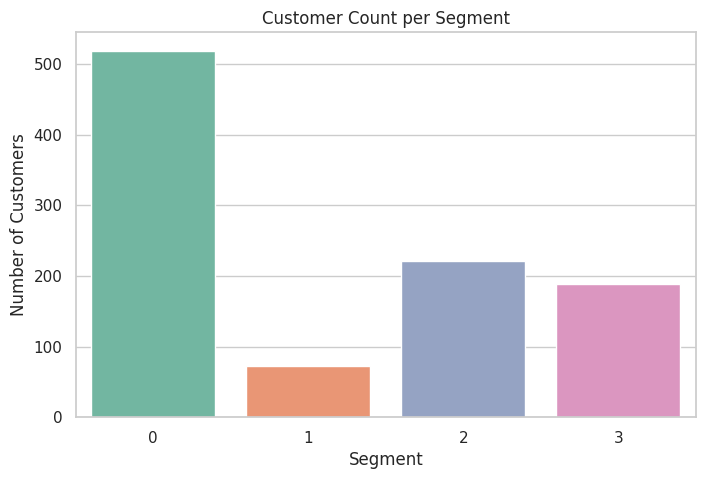

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(x='Segment', data=df_fe, palette='Set2')
plt.title("Customer Count per Segment")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.show()


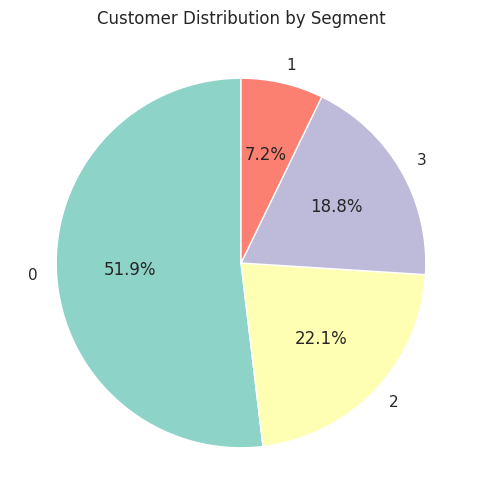

In [13]:
segment_counts = df_fe['Segment'].value_counts()
segment_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set3'), figsize=(6,6))
plt.title("Customer Distribution by Segment")
plt.ylabel("")
plt.show()
